In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import requests
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Embedding, Concatenate, MultiHeadAttention
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras import Input
from keras import Model

In [2]:
#import data from csv file
df1 = pd.read_csv('S&P BSE Teck Historical Data.csv')
df1 = df1[::-1]

In [3]:
# API details (replace with actual values)
api_url = "https://api.mfapi.in/mf/120594"
api_params = {"scheme_code": 120594}  # Assuming scheme_code is the required parameter

# Make the API request
response = requests.get(api_url, params=api_params)
data = response.json()

# Create a DataFrame
df = pd.DataFrame(data["data"])  # Extract the "data" list from the response
df = df[::-1]

# Add calculated column (replace with your calculation logic)
#df["calculated_column"] = df["nav"] * 1.1  # Example: increase NAV by 10%

# Save to CSV
#df.to_csv("fund_data.csv", index=False)


In [4]:
# Rename the column first
df1.rename(columns={"Date": "date"}, inplace=True)

# Now convert the date format
df1["date"] = pd.to_datetime(df1["date"], format='%m/%d/%Y').dt.strftime("%d-%m-%Y")

In [5]:
print(df1.head())

            date     Price      Open      High       Low    Vol. Change %
2735  02-01-2013  3,445.46  3,454.78  3,459.53  3,441.20   7.90K    0.20%
2734  03-01-2013  3,491.06  3,453.27  3,496.87  3,448.30  12.69K    1.32%
2733  04-01-2013  3,514.91  3,502.28  3,517.65  3,498.69   8.84K    0.68%
2732  07-01-2013  3,519.49  3,524.77  3,537.07  3,514.18  10.46K    0.13%
2731  08-01-2013  3,514.39  3,516.38  3,522.73  3,495.37   8.36K   -0.14%


In [6]:
print(df.head())

            date       nav
2784  02-01-2013  19.47000
2783  03-01-2013  19.68000
2782  04-01-2013  19.74000
2781  07-01-2013  19.70000
2780  08-01-2013  19.71000


In [7]:
print(df1['date'].duplicated().sum())
print(df['date'].duplicated().sum())
print(df1['date'].isna().sum())
print(df['date'].isna().sum())
print(len(df1))
print(len(df))

0
0
0
0
2736
2785


In [8]:
print(df1.head())
print(df.head())
print(df1.tail())
print(df.tail())

            date     Price      Open      High       Low    Vol. Change %
2735  02-01-2013  3,445.46  3,454.78  3,459.53  3,441.20   7.90K    0.20%
2734  03-01-2013  3,491.06  3,453.27  3,496.87  3,448.30  12.69K    1.32%
2733  04-01-2013  3,514.91  3,502.28  3,517.65  3,498.69   8.84K    0.68%
2732  07-01-2013  3,519.49  3,524.77  3,537.07  3,514.18  10.46K    0.13%
2731  08-01-2013  3,514.39  3,516.38  3,522.73  3,495.37   8.36K   -0.14%
            date       nav
2784  02-01-2013  19.47000
2783  03-01-2013  19.68000
2782  04-01-2013  19.74000
2781  07-01-2013  19.70000
2780  08-01-2013  19.71000
         date      Price       Open       High        Low    Vol. Change %
4  16-01-2024  16,544.56  16,740.20  16,740.20  16,501.08  73.74K   -1.12%
3  17-01-2024  16,580.51  16,424.69  16,656.80  16,390.26  75.05K    0.22%
2  18-01-2024  16,548.78  16,517.33  16,574.08  16,344.10  50.58K   -0.19%
1  19-01-2024  16,762.62  16,673.91  16,779.41  16,673.79  59.58K    1.29%
0  20-01-2024  16,6

In [9]:
df1["Change %"] = df1["Change %"].str.replace("%", "")
#do it for each column except date
df1["Price"] = df1["Price"].str.replace(",", "")
df1["Open"] = df1["Open"].str.replace(",", "")
df1["High"] = df1["High"].str.replace(",", "")
df1["Low"] = df1["Low"].str.replace(",", "")
numeric_columns = df1.columns.difference(["date", "Vol."])

In [10]:
#convert Vol. to numeric and replace the values in the same column
#if K then multiply by 1000, if M then multiply by 1000000, if B then multiply by 1000000000
#create a function to do this
def adjust_volume(value):
    if pd.isna(value):
        return value  # Keep NaN as is

    if value.endswith("M"):
        return pd.to_numeric(value[:-1]) * 1000000
    elif value.endswith("B"):
        return pd.to_numeric(value[:-1]) * 1000000000
    elif value.endswith("K"):
        return pd.to_numeric(value[:-1]) * 1000
    else:
        return pd.to_numeric(value)  # No modifier, assume original value
df1['Vol.'] = df1['Vol.'].apply(adjust_volume)



In [11]:
nan_count = df1['Vol.'].isna().sum()
print(nan_count)

4


In [12]:
nan_indices = df1[df1['Vol.'].isna()].index
print(nan_indices)

Index([356, 206, 108, 0], dtype='int64')


In [13]:
df1['Vol.'] = df1['Vol.'].interpolate()

In [14]:
nan_count = df1['Vol.'].isna().sum()
print(nan_count)

0


In [15]:
print(df1.dtypes)

date         object
Price        object
Open         object
High         object
Low          object
Vol.        float64
Change %     object
dtype: object


In [16]:

#df1.dtypes
df1[numeric_columns] = df1[numeric_columns].apply(pd.to_numeric)
#df1[numeric_columns] = df1[numeric_columns].astype(float64)
df["nav"] = df["nav"].apply(pd.to_numeric)


In [17]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29411 sha256=0bac2a83978c3fe3c33058e56ebff7f5b34ff5bf5b1f8febe66cfce93397a6b0
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [18]:
import ta

# Assuming your df index data is in a DataFrame 'df'
df['RSI'] = ta.momentum.rsi(df['nav'], window=14)
macd = ta.trend.macd_diff(df['nav'])
df['MACD'] = macd
macd_signal = ta.trend.macd_signal(df['nav'])
df['MACD_Signal'] = macd_signal
bandwidth = 2
indicator_bb = ta.volatility.BollingerBands(close=df['nav'], window=20, window_dev=2)
df['BB_Upper'] = indicator_bb.bollinger_hband()
df['BB_Middle'] = indicator_bb.bollinger_mavg()
df['BB_Lower'] = indicator_bb.bollinger_lband()

In [19]:
#clean the new columns
print(df['BB_Upper'].isna().sum())
print(df['BB_Lower'].isna().sum())
print(df['BB_Middle'].isna().sum())
print(df['RSI'].isna().sum())
print(df['MACD'].isna().sum())
print(df['MACD_Signal'].isna().sum())

19
19
19
13
33
33


In [20]:
# drop 33 rows
df = df.iloc[33:]
print(df1.dtypes)

date         object
Price       float64
Open        float64
High        float64
Low         float64
Vol.        float64
Change %    float64
dtype: object


In [21]:
#check the new columns again
print(df['BB_Upper'].isna().sum())
print(df['BB_Lower'].isna().sum())
print(df['BB_Middle'].isna().sum())
print(df['RSI'].isna().sum())
print(df['MACD'].isna().sum())
print(df['MACD_Signal'].isna().sum())

0
0
0
0
0
0


In [22]:
#keep only the dates in df1 that are in df
df1 = df1[df1['date'].isin(df['date'])]
print(len(df1))
df = df[df['date'].isin(df1['date'])]
print(len(df))

2686
2686


In [23]:
merged_data = df.merge(df1, on="date")
print(merged_data.head())
print(merged_data.dtypes)

         date    nav        RSI      MACD  MACD_Signal   BB_Upper  BB_Middle  \
0  18-02-2013  20.73  50.497624 -0.058591     0.140630  21.293071    20.9335   
1  19-02-2013  21.03  60.286057 -0.037770     0.131188  21.268631    20.9255   
2  20-02-2013  21.38  68.189104 -0.001599     0.130788  21.313524    20.9345   
3  21-02-2013  21.27  63.886142  0.012944     0.134024  21.349256    20.9455   
4  22-02-2013  21.43  67.134778  0.030369     0.141616  21.395249    20.9555   

    BB_Lower    Price     Open     High      Low     Vol.  Change %  
0  20.573929  3760.89  3778.80  3778.80  3750.41   6590.0     -0.47  
1  20.582369  3802.35  3765.17  3810.22  3748.82   8760.0      1.10  
2  20.555476  3813.27  3813.55  3819.52  3805.31   9610.0      0.29  
3  20.541744  3772.99  3793.35  3816.14  3768.97  12610.0     -1.06  
4  20.515751  3822.99  3774.42  3838.31  3774.42   9390.0      1.33  
date            object
nav            float64
RSI            float64
MACD           float64
MACD_Si

In [24]:
#clean the new columns
print(merged_data['BB_Upper'].isna().sum())
print(merged_data['BB_Lower'].isna().sum())
print(merged_data['BB_Middle'].isna().sum())
print(merged_data['RSI'].isna().sum())
print(merged_data['MACD'].isna().sum())
print(merged_data['MACD_Signal'].isna().sum())

0
0
0
0
0
0


In [25]:
risk_free_rate = 0.07

# Calculate the returns for the mutual fund and benchmark index
merged_data['Fund_Return'] = (merged_data['Price'] - merged_data['nav']) / merged_data['nav']
merged_data['Index_Return'] = merged_data['Change %'] / 100  # Assuming change% is in percentage

# Calculate the beta value (covariance/variance)
covariance_matrix = merged_data[['Fund_Return', 'Index_Return']].cov()
beta = covariance_matrix.loc['Fund_Return', 'Index_Return'] / covariance_matrix.loc['Index_Return', 'Index_Return']

# Calculate the expected return of the mutual fund using CAPM
merged_data['Expected_Fund_Return'] = risk_free_rate + beta * (merged_data['Index_Return'] - risk_free_rate)

# Calculate alpha value
merged_data['Alpha'] = merged_data['Fund_Return'] - merged_data['Expected_Fund_Return']

# Display the dataframe with alpha values
print(merged_data[['nav', 'Price', 'Index_Return', 'Expected_Fund_Return', 'Fund_Return', 'Alpha']])

         nav     Price  Index_Return  Expected_Fund_Return  Fund_Return  \
0      20.73   3760.89       -0.0047             -0.805863   180.422576   
1      21.03   3802.35        0.0110             -0.621779   179.805991   
2      21.38   3813.27        0.0029             -0.716753   177.356876   
3      21.27   3772.99       -0.0106             -0.875041   176.385520   
4      21.43   3822.99        0.0133             -0.594812   177.394307   
...      ...       ...           ...                   ...          ...   
2681  195.54  16732.45        0.0179             -0.540876    84.570472   
2682  193.88  16544.56       -0.0112             -0.882076    84.334021   
2683  194.08  16580.51        0.0022             -0.724960    84.431317   
2684  193.29  16548.78       -0.0019             -0.773033    84.616328   
2685  196.09  16762.62        0.0129             -0.599502    84.484318   

           Alpha  
0     181.228439  
1     180.427771  
2     178.073628  
3     177.260561  
4   

In [26]:
print(merged_data.dtypes)

date                     object
nav                     float64
RSI                     float64
MACD                    float64
MACD_Signal             float64
BB_Upper                float64
BB_Middle               float64
BB_Lower                float64
Price                   float64
Open                    float64
High                    float64
Low                     float64
Vol.                    float64
Change %                float64
Fund_Return             float64
Index_Return            float64
Expected_Fund_Return    float64
Alpha                   float64
dtype: object


In [27]:
from sklearn.feature_selection import mutual_info_regression
X = merged_data.drop(['nav','date'], axis=1)
y = merged_data['nav']
columns_with_nan = X.columns[X.isna().any()].tolist()
print(columns_with_nan)

[]


In [28]:
mutual_info = mutual_info_regression(X, y)
mutual_info = pd.Series(mutual_info, index=X.columns)
mutual_info.sort_values(ascending=False, inplace=True)
print(mutual_info)

BB_Upper                2.930613
Price                   2.923974
BB_Middle               2.869908
Low                     2.781264
High                    2.757899
BB_Lower                2.740464
Open                    2.599539
Alpha                   2.251824
Fund_Return             2.250718
MACD_Signal             1.145425
Vol.                    0.620661
MACD                    0.472232
RSI                     0.408721
Change %                0.000000
Index_Return            0.000000
Expected_Fund_Return    0.000000
dtype: float64


In [29]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor()
rf_model.fit(X, y)
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importances_sorted = feature_importances.sort_values(ascending=False)
print("\nFeature Importance from Random Forest:")
print(feature_importances_sorted)


Feature Importance from Random Forest:
Price                   0.459622
BB_Upper                0.235683
Low                     0.130628
High                    0.075076
BB_Middle               0.045809
BB_Lower                0.030209
Open                    0.018602
Alpha                   0.002363
Fund_Return             0.001456
RSI                     0.000290
MACD_Signal             0.000113
MACD                    0.000111
Vol.                    0.000017
Change %                0.000007
Expected_Fund_Return    0.000007
Index_Return            0.000006
dtype: float64


In [30]:
#dropping the unecessary columns
merged_data = merged_data.drop(['Change %','Index_Return','Expected_Fund_Return'], axis=1)

In [31]:
print(merged_data.dtypes)
print(merged_data.shape)

date            object
nav            float64
RSI            float64
MACD           float64
MACD_Signal    float64
BB_Upper       float64
BB_Middle      float64
BB_Lower       float64
Price          float64
Open           float64
High           float64
Low            float64
Vol.           float64
Fund_Return    float64
Alpha          float64
dtype: object
(2686, 15)


In [32]:
merged_data.head()

,date,nav,RSI,MACD,MACD_Signal,BB_Upper,BB_Middle,BB_Lower,Price,Open,High,Low,Vol.,Fund_Return,Alpha
0,18-02-2013,20.73,50.497624,-0.058591,0.140630,21.293071,20.9335,20.573929,3760.89,3778.80,3778.80,3750.41,6590.0,180.422576,181.228439
1,19-02-2013,21.03,60.286057,-0.037770,0.131188,21.268631,20.9255,20.582369,3802.35,3765.17,3810.22,3748.82,8760.0,179.805991,180.427771
2,20-02-2013,21.38,68.189104,-0.001599,0.130788,21.313524,20.9345,20.555476,3813.27,3813.55,3819.52,3805.31,9610.0,177.356876,178.073628
3,21-02-2013,21.27,63.886142,0.012944,0.134024,21.349256,20.9455,20.541744,3772.99,3793.35,3816.14,3768.97,12610.0,176.385520,177.260561
4,22-02-2013,21.43,67.134778,0.030369,0.141616,21.395249,20.9555,20.515751,3822.99,3774.42,3838.31,3774.42,9390.0,177.394307,177.989119


In [33]:
merged_data['nav_shifted'] = merged_data['nav'].shift(-1)
merged_data.dropna(inplace=True)

In [34]:
merged_data.head()

,date,nav,RSI,MACD,MACD_Signal,BB_Upper,BB_Middle,BB_Lower,Price,Open,High,Low,Vol.,Fund_Return,Alpha,nav_shifted
0,18-02-2013,20.73,50.497624,-0.058591,0.140630,21.293071,20.9335,20.573929,3760.89,3778.80,3778.80,3750.41,6590.0,180.422576,181.228439,21.03
1,19-02-2013,21.03,60.286057,-0.037770,0.131188,21.268631,20.9255,20.582369,3802.35,3765.17,3810.22,3748.82,8760.0,179.805991,180.427771,21.38
2,20-02-2013,21.38,68.189104,-0.001599,0.130788,21.313524,20.9345,20.555476,3813.27,3813.55,3819.52,3805.31,9610.0,177.356876,178.073628,21.27
3,21-02-2013,21.27,63.886142,0.012944,0.134024,21.349256,20.9455,20.541744,3772.99,3793.35,3816.14,3768.97,12610.0,176.385520,177.260561,21.43
4,22-02-2013,21.43,67.134778,0.030369,0.141616,21.395249,20.9555,20.515751,3822.99,3774.42,3838.31,3774.42,9390.0,177.394307,177.989119,21.66


In [35]:
'''
# Convert 'date' column to datetime index
merged_data['date'] = pd.to_datetime(merged_data['date'],format = 'mixed')
merged_data.set_index('date', inplace=True)

# Separate features (X) and target variable (y)
X = merged_data.drop(['nav'], axis=1)
y = merged_data['nav'].values.reshape(-1, 1)

# Split the data into train and test sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Scale the features using MinMaxScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define a function to reshape data for LSTM input
def reshape_data(X, time_steps):
    X_reshaped = []
    for i in range(len(X) - time_steps):
        X_reshaped.append(X[i:(i + time_steps)])
    return np.array(X_reshaped)

# Define the number of time steps
time_steps = 14  # You can adjust this value based on the temporal dependencies in your data

# Reshape the data for LSTM input
X_train_reshaped = reshape_data(X_train_scaled, time_steps)
X_test_reshaped = reshape_data(X_test_scaled, time_steps)
y_train_reshaped = y_train[time_steps:]
y_test_reshaped = y_test[time_steps:]
'''

"\n# Convert 'date' column to datetime index\nmerged_data['date'] = pd.to_datetime(merged_data['date'],format = 'mixed')\nmerged_data.set_index('date', inplace=True)\n\n# Separate features (X) and target variable (y)\nX = merged_data.drop(['nav'], axis=1)\ny = merged_data['nav'].values.reshape(-1, 1)\n\n# Split the data into train and test sets (e.g., 80% train, 20% test)\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)\n\n# Scale the features using MinMaxScaler\nscaler = StandardScaler()\nX_train_scaled = scaler.fit_transform(X_train)\nX_test_scaled = scaler.transform(X_test)\n\n# Define a function to reshape data for LSTM input\ndef reshape_data(X, time_steps):\n    X_reshaped = []\n    for i in range(len(X) - time_steps):\n        X_reshaped.append(X[i:(i + time_steps)])\n    return np.array(X_reshaped)\n\n# Define the number of time steps\ntime_steps = 14  # You can adjust this value based on the temporal dependencies in your data\n\n# Reshap

In [36]:
'''
# Define the LSTM model architecture
# Define the LSTM model architecture
model = Sequential([
    LSTM(units=128, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(units=64, return_sequences=True),
    Dropout(0.2),
    LSTM(units=32, return_sequences=False),
    Dropout(0.2),
    Dense(units=1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_reshaped, y_train_reshaped, epochs=50, batch_size=32, validation_split=0.2)
'''

"\n# Define the LSTM model architecture\n# Define the LSTM model architecture\nmodel = Sequential([\n    LSTM(units=128, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), return_sequences=True),\n    Dropout(0.2),\n    LSTM(units=64, return_sequences=True),\n    Dropout(0.2),\n    LSTM(units=32, return_sequences=False),\n    Dropout(0.2),\n    Dense(units=1)\n])\n\n# Compile the model\nmodel.compile(optimizer='adam', loss='mean_squared_error')\n\n# Train the model\nhistory = model.fit(X_train_reshaped, y_train_reshaped, epochs=50, batch_size=32, validation_split=0.2)\n"

In [37]:
'''
# Evaluate the model on the test set
y_pred = model.predict(X_test_reshaped)
mae = mean_absolute_error(y_test_reshaped, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_reshaped, y_pred))
print("Mean Absolute Error on Test Set:", mae)
print("Root Mean Squared Error on Test Set:", rmse
'''

'\n# Evaluate the model on the test set\ny_pred = model.predict(X_test_reshaped)\nmae = mean_absolute_error(y_test_reshaped, y_pred)\nrmse = np.sqrt(mean_squared_error(y_test_reshaped, y_pred))\nprint("Mean Absolute Error on Test Set:", mae)\nprint("Root Mean Squared Error on Test Set:", rmse\n'

In [38]:
X = merged_data.drop(['nav_shifted','date'], axis=1)
y = merged_data['nav_shifted']

In [39]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y.values.reshape(-1, 1))

In [40]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [41]:
def reshape_data(X, time_steps):
    X_reshaped = []
    for i in range(len(X) - time_steps):
        X_reshaped.append(X[i:(i + time_steps)])
    return np.array(X_reshaped)

# Define the number of time steps
time_steps = 14  # You can adjust this value based on the temporal dependencies in your data

# Reshape the data for LSTM input
X_train = reshape_data(X_train, time_steps)
X_test = reshape_data(X_test, time_steps)
y_train = y_train[time_steps:]
y_test = y_test[time_steps:]

In [42]:
model = Sequential()
model.add(LSTM(64, input_shape=(time_steps, X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

Epoch 1/50
60/60 [==============================] - 4s 11ms/step - loss: 5.2125e-04 - val_loss: 0.0029
Epoch 2/50
60/60 [==============================] - 0s 4ms/step - loss: 5.5067e-05 - val_loss: 8.9411e-04
Epoch 3/50
60/60 [==============================] - 0s 4ms/step - loss: 3.9709e-05 - val_loss: 7.8554e-04
Epoch 4/50
60/60 [==============================] - 0s 4ms/step - loss: 4.3770e-05 - val_loss: 4.6038e-04
Epoch 5/50
60/60 [==============================] - 0s 4ms/step - loss: 3.7490e-05 - val_loss: 4.4766e-04
Epoch 6/50
60/60 [==============================] - 0s 4ms/step - loss: 3.3234e-05 - val_loss: 6.2522e-04
Epoch 7/50
60/60 [==============================] - 0s 6ms/step - loss: 4.1218e-05 - val_loss: 4.5511e-04
Epoch 8/50
60/60 [==============================] - 0s 7ms/step - loss: 3.7637e-05 - val_loss: 4.2215e-04
Epoch 9/50
60/60 [==============================] - 1s 8ms/step - loss: 3.8632e-05 - val_loss: 6.4005e-04
Epoch 10/50
60/60 [==============================

In [43]:
y_pred = model.predict(X_test)

17/17 [==============================] - 1s 7ms/step


In [44]:
y_pred_scaled = scaler.inverse_transform(y_pred)
y_test_scaled = scaler.inverse_transform(y_test)

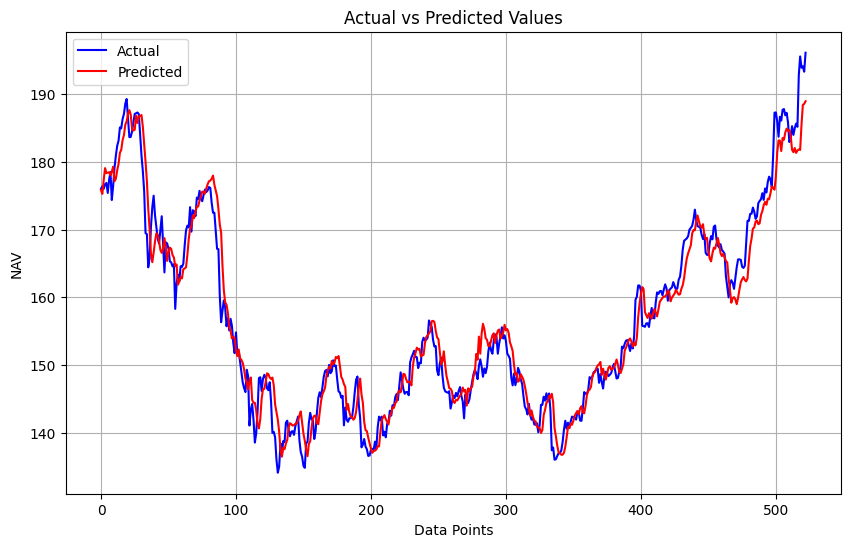

In [47]:
import matplotlib.pyplot as plt

# Assuming 'y_test' contains the actual target values and 'y_pred' contains the predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_scaled, label='Actual', color='blue')
plt.plot(y_pred_scaled, label='Predicted', color='red')
plt.title('Actual vs Predicted Values')
plt.xlabel('Data Points')
plt.ylabel('NAV')
plt.legend()
plt.grid(True)
plt.show()


In [46]:

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Mean Absolute Error on Test Set:", mae)
print("Root Mean Squared Error on Test Set:", rmse)

Mean Absolute Error on Test Set: 0.013508030702348298
Root Mean Squared Error on Test Set: 0.018196238338824642
